In [ ]:
pip install keras-tuner --upgrade

In [3]:
import tensorflow as tf
print(tf.__version__)

2.11.0


The datasets needed for this project were downloaded from this link: https://docs.google.com/file/d/0B04GJPshIjmPRnZManQwWEdTZjg/edit?resourcekey=0-betyQkEmWZgp8z0DFxWsHw. They were then unzipped and stored in gdrive for use in this colab notebook. I only used the training set and split it into train, val and test set later in the notebook to maintain uniformity.
After skimming through the csv file, I have renamed it as "training_cleaned".

In [7]:
# Run this to connect the drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [51]:
# Necessary imports
import csv
import random
#import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
#from scipy.stats import linregress

In [8]:
# Lets see how each sample is
sentiment_tweet_data = "/content/gdrive/MyDrive/data_files/training_cleaned.csv"
with open(sentiment_tweet_data, "r") as csvfile:
  print(f"The header looks like this:\n\n{csvfile.readline()}")
  print(f"Each data example looks like this:\n\n{csvfile.readline()}")

The header looks like this:

"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

Each data example looks like this:

"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"



As we can see each data example has a label, id,datetime,query flag, handle, a string sentence(the tweet).
label : 0 for negative, 4 for positive.
id: id of the tweet.
datetime: date and time of the tweet
flag: the query. If theree is no query, this value is NO_QUERY.
handle: the handle of the user who tweeted.
text : text , the tweet.


###Preprocessing: Parsing and Spliting


Parsing the raw data. Changing positive tweet labels to integer 1 and negative tweet as integer 0.

In [9]:
def parse_data_from_file(filename):
    """
    Extracts sentences and labels from a CSV file
    Args:
        filename (string): path to the CSV file
    Returns:
        sentences, labels (list of string, list of string): tuple containing lists of sentences and labels
    """
    
    sentences = []
    labels = []
    
    with open(filename, 'r') as csvfile:
       
        reader = csv.reader(csvfile, delimiter=",")
        for line in reader:
            sentences.append(line[5])
            if line[0]=="4":
                labels.append(1)
            else:
                labels.append(0)
                  
    return sentences, labels

In [10]:
# see if parsing worked
sentences, labels = parse_data_from_file(sentiment_tweet_data)
print(f"dataset has {len(sentences)} examples\n")
print(f"Tweet of third example is:\n{sentences[2]}\n")
print(f"The label of third example is: {labels[2]}")


dataset has 1600000 examples

Tweet of third example is:
@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds

The label of third example is: 0


Taking only subset of the data to save execution time. 

In [11]:
#zip sentences and labels together
sentences_labels = list(zip(sentences, labels))
max_examples = 300000 #300,000

#random sampling
random.seed(52)
sentences_labels = random.sample(sentences_labels, max_examples)

#unzip
sentences, labels = zip(*sentences_labels)
print(f"There are {len(sentences)} sentences and {len(labels)} labels now.\n")

There are 300000 sentences and 300000 labels now.



Splitting the data into train, val and test set with helper function.

In [12]:
def data_split(sentences, labels, tp=0.8, vp=0.1):
  """
  Splits the data into train, validation and test split.
  train split is controlled by train proportion, tp.
  val split is controlled by val proportion, vp.
  test split, sp (defined later), is 1-(tp+vp).

  """
  sp = 1 - tp - vp
  train_size = round(len(sentences) * tp)
  val_size = round(len(sentences) * vp)
  test_size = len(sentences) - (train_size + val_size)

  train_sentences = sentences[:train_size]
  val_sentences = sentences[train_size: (train_size+val_size)]
  test_sentences = sentences[(train_size+val_size):]

  train_labels = labels[:train_size]
  val_labels = labels[train_size: (train_size+val_size)]
  test_labels = labels[(train_size+val_size):]

  return train_sentences, val_sentences, test_sentences, train_labels, val_labels, test_labels

In [13]:
# see if the function worked

train_sentences, val_sentences, test_sentences, train_labels, val_labels, test_labels = data_split(sentences, labels)

print(f"Number of training sentences: {len(train_sentences)}")
print(f"Number of validation sentences: {len(val_sentences)}")
print(f"Number of test sentences: {len(test_sentences)}")

print(f"Number of training labels: {len(train_labels)}")
print(f"Number of validation labels: {len(val_labels)}")
print(f"Number of test labels: {len(test_labels)}")


Number of training sentences: 240000
Number of validation sentences: 30000
Number of test sentences: 30000
Number of training labels: 240000
Number of validation labels: 30000
Number of test labels: 30000


In [41]:
ts = list(train_sentences)
type(ts)
print(ts[1])

Couldn't help but be teary-eyed when I hear **Don't Leave This Place**. Makes me want to cry. 


###Preprocessing: Tokenization, sequences, truncting and padding.

Fitting a Tokenizer.

In [14]:
def fit_tokenizer(train_sentences):

  #instantiate the Tokenizer class
  tokenizer = Tokenizer(oov_token="<OOV>")

  #fit it to the training_sentences
  tokenizer.fit_on_texts(train_sentences)

  return tokenizer

Padding and truncating.

In [15]:
def seq_pad(sentences, tokenizer):

  sequences = tokenizer.texts_to_sequences(sentences)

  pad_trunc = pad_sequences(sequences, maxlen=16, truncating="post", padding="post")

  return pad_trunc

In [16]:
# see if it worked
tokenizer = fit_tokenizer(train_sentences)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print(f"Vocab size is: {vocab_size}\n")
print(f"Index of the word 'you' is: {word_index['you']}")

Vocab size is: 185544

Index of the word 'you' is: 8


In [17]:
train_pad_trunc = seq_pad(train_sentences, tokenizer)
val_pad_trunc = seq_pad(val_sentences, tokenizer)
test_pad_trunc = seq_pad(test_sentences, tokenizer)

print(f"Training sequences have shape: {train_pad_trunc.shape}\n")
print(f"Validation sequences have shape: {val_pad_trunc.shape}\n")
print(f"Test sequences have shape: {test_pad_trunc.shape}")

Training sequences have shape: (240000, 16)

Validation sequences have shape: (30000, 16)

Test sequences have shape: (30000, 16)


Converting labels to numpy arrays.


In [18]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)


### Loading predefined Glove Embeddings for transfer learning.

The Glove embedding file is found at this page: https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt.
I downloaded it, unzipped it and saved it to my gdrive.

In [20]:
#downloading Glove word embeddings and saving it as a dictionary
glove_file = "/content/gdrive/MyDrive/data_files/glove.6B.100d.txt"

glove_embed = {}

with open(glove_file) as g:
  for line in g:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    glove_embed[word] = vector


In [21]:
#seeing if it worked

test_word = 'cat'
test_vector = glove_embed[test_word]
print(f"Glove vector representation of {test_word} is: \n{test_vector}\n")
print(f"Dimension of each vector is: {test_vector.shape}")

Glove vector representation of cat is: 
[ 0.23088    0.28283    0.6318    -0.59411   -0.58599    0.63255
  0.24402   -0.14108    0.060815  -0.7898    -0.29102    0.14287
  0.72274    0.20428    0.1407     0.98757    0.52533    0.097456
  0.8822     0.51221    0.40204    0.21169   -0.013109  -0.71616
  0.55387    1.1452    -0.88044   -0.50216   -0.22814    0.023885
  0.1072     0.083739   0.55015    0.58479    0.75816    0.45706
 -0.28001    0.25225    0.68965   -0.60972    0.19578    0.044209
 -0.31136   -0.68826   -0.22721    0.46185   -0.77162    0.10208
  0.55636    0.067417  -0.57207    0.23735    0.4717     0.82765
 -0.29263   -1.3422    -0.099277   0.28139    0.41604    0.10583
  0.62203    0.89496   -0.23446    0.51349    0.99379    1.1846
 -0.16364    0.20653    0.73854    0.24059   -0.96473    0.13481
 -0.0072484  0.33016   -0.12365    0.27191   -0.40951    0.021909
 -0.6069     0.40755    0.19566   -0.41802    0.18636   -0.032652
 -0.78571   -0.13847    0.044007  -0.084423   

Representing the words in my vocab using this embedding. If any word in my vocab is not present in glove_embed, that word is represented by a row of zeros in embedding_matrix.

In [22]:
# an empty numpy array with the right dimension
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size+1, embedding_dim))

# iterating over all of the words in my vocabulary and if the vector representation for 
# each word exists within GloVe's representations, saving it in the embedding_matrix array
for word, vocab_ind in word_index.items():
    embedding_vector = glove_embed.get(word)
    if embedding_vector is not None:
        embedding_matrix[vocab_ind] = embedding_vector

### Model Definition, Training and Fine-tuning.

In [68]:
def get_model(vocab_size, embedding_dim, embedding_matrix):
    """
    Creates a binary sentiment classifier model
    
    """
    ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        # setting embedding layer with glove embedding weights
        tf.keras.layers.Embedding(input_dim= vocab_size+1, output_dim=embedding_dim, input_length=16, weights=[embedding_matrix], trainable=False), 
        #input_dim = vocab_size+1
        #output_dim = embedding vector size for each word(here:100)
        #input_lenght= max length of sequence fed
        #trainable set False to not to train this pretrained embeddings
        
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Conv1D(16, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 

       
    return model

In [69]:
model = get_model(vocab_size, embedding_dim, embedding_matrix)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 16, 100)           18554500  
                                                                 
 dropout_2 (Dropout)         (None, 16, 100)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 16)            8016      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 20)                340       
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                      

In [70]:
# Train the model
history = model.fit(train_pad_trunc, train_labels, epochs=4, validation_data=(val_pad_trunc, val_labels))

Epoch 1/4
7500/7500 [==============================] - 34s 4ms/step - loss: 0.5653 - accuracy: 0.7006 - val_loss: 0.5279 - val_accuracy: 0.7329
Epoch 2/4
7500/7500 [==============================] - 35s 5ms/step - loss: 0.5361 - accuracy: 0.7241 - val_loss: 0.5224 - val_accuracy: 0.7366
Epoch 3/4
7500/7500 [==============================] - 34s 4ms/step - loss: 0.5267 - accuracy: 0.7325 - val_loss: 0.5157 - val_accuracy: 0.7426
Epoch 4/4
7500/7500 [==============================] - 33s 4ms/step - loss: 0.5224 - accuracy: 0.7340 - val_loss: 0.5108 - val_accuracy: 0.7458


Trying Keras Tuner.

In [85]:
def build_model(hp):
  ### START CODE HERE
    
    model = tf.keras.Sequential([ 
        # setting embedding layer with glove embedding weights
        tf.keras.layers.Embedding(input_dim= vocab_size+1, output_dim=100, input_length=16, weights=[embedding_matrix], trainable=False), 
        #input_dim = vocab_size+1
        #output_dim = embedding vector size for each word(here:100)
        #input_lenght= max length of sequence fed
        #trainable set False to not to train this pretrained embeddings
        
        tf.keras.layers.Dropout(rate= hp.Choice('drop_out_rate_1', values=[0.05, 0.1, 0.15, 0.2])),
        
        tf.keras.layers.Conv1D(
            filters=hp.Choice('conv_1d_1_filter', values=[4,8,12,16,24]),
            kernel_size=hp.Choice('kernel_size_1', values=[2,3,4,5]),
            activation='relu'
            ),

        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(
            units=hp.Choice('dense_units_1', values=[5,10,15,20,25]),
            activation='relu'
            ),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    
    model.compile(loss='binary_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])),
                  metrics=['accuracy'])
    
    return model

In [86]:
#initialzie the tuner
import keras_tuner

#from tensorflow import keras
import keras
#creating randomsearch object

tuner = keras_tuner.RandomSearch(build_model,
                                 objective='val_accuracy',
                                 max_trials=10)

In [87]:
# search in the random search grid for best parameters
tuner.search(train_pad_trunc, train_labels, epochs=5, validation_data=[val_pad_trunc, val_labels])

Trial 10 Complete [00h 02m 54s]
val_accuracy: 0.7420666813850403

Best val_accuracy So Far: 0.7455999851226807
Total elapsed time: 00h 23m 10s


In [88]:
model_tuned=tuner.get_best_models(num_models=1)[0]
#summary of best model
model_tuned.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 16, 100)           18554500  
                                                                 
 dropout (Dropout)           (None, 16, 100)           0         
                                                                 
 conv1d (Conv1D)             (None, 15, 12)            2412      
                                                                 
 global_max_pooling1d (Globa  (None, 12)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                130       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                        

In [89]:
history2 = model_tuned.fit(train_pad_trunc, train_labels, epochs=10, validation_data=(val_pad_trunc, val_labels))

Epoch 1/10
7500/7500 [==============================] - 33s 4ms/step - loss: 0.5352 - accuracy: 0.7283 - val_loss: 0.5138 - val_accuracy: 0.7445
Epoch 2/10
7500/7500 [==============================] - 30s 4ms/step - loss: 0.5351 - accuracy: 0.7293 - val_loss: 0.5103 - val_accuracy: 0.7471
Epoch 3/10
7500/7500 [==============================] - 31s 4ms/step - loss: 0.5345 - accuracy: 0.7313 - val_loss: 0.5191 - val_accuracy: 0.7499
Epoch 4/10
7500/7500 [==============================] - 31s 4ms/step - loss: 0.5335 - accuracy: 0.7306 - val_loss: 0.5119 - val_accuracy: 0.7510
Epoch 5/10
7500/7500 [==============================] - 30s 4ms/step - loss: 0.5330 - accuracy: 0.7311 - val_loss: 0.5116 - val_accuracy: 0.7487
Epoch 6/10
7500/7500 [==============================] - 31s 4ms/step - loss: 0.5320 - accuracy: 0.7325 - val_loss: 0.5120 - val_accuracy: 0.7495
Epoch 7/10
7500/7500 [==============================] - 30s 4ms/step - loss: 0.5318 - accuracy: 0.7332 - val_loss: 0.5257 - val_ac

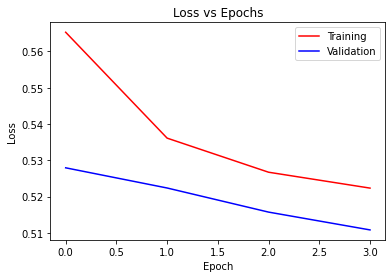

In [90]:
#plot training and validation loss per epoch
epochs = [*range(20)]

plt.plot(history.history["loss"], 'r')
plt.plot(history.history["val_loss"], 'b')
plt.title("Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"], loc='upper right')
plt.show()

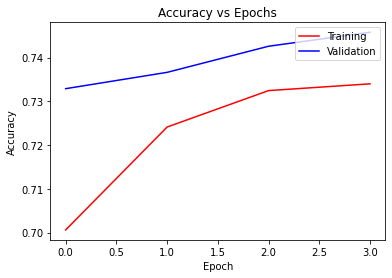

In [91]:
#plot training and validation accuracy per epoch

plt.plot(history.history["accuracy"], 'r')
plt.plot(history.history["val_accuracy"], 'b')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training", "Validation"], loc='upper right')
plt.show()

### Predictions and Results

In [92]:
# predict using the model in test set
pred_labels = model.predict(test_pad_trunc)
len_pred = len(pred_labels)
pred_labels_2 = pred_labels.reshape((len_pred,))
print(pred_labels_2.shape)
print(type(pred_labels_2))


938/938 [==============================] - 3s 3ms/step
(30000,)
<class 'numpy.ndarray'>


In [93]:
#converting test labels and predicted labels np array to list
pred_list = list(pred_labels_2)
y_pred = [1 if p>=0.5 else 0 for p in pred_list]
#print(y_pred)
test_labels_list = list(test_labels)
#print(test_labels_list)

In [94]:

pred_acc = accuracy_score(test_labels_list, y_pred)
print(f"Accuracy score is: {pred_acc}")

Accuracy score is: 0.7403


In [95]:
labels_list = ["negative", "positive"]

In [96]:
#lets see for some sample
r = random.randint(0, len_pred)

#the sentence corresponding to this is:
s = list(test_sentences)[r]
print(s)
print()
print(f"The true label associated with it is: {test_labels[r]} which means {labels_list[test_labels[r]]}\n")
print(f"The predicted label is: {y_pred[r]} which meanss {labels_list[test_labels[r]]}")



i now update on posterous as well as here on twitter. so do check out both for updates 

The true label associated with it is: 1 which means positive

The predicted label is: 1 which meanss positive


In [97]:
conf_mat = confusion_matrix(y_true=test_labels_list, y_pred=y_pred)
print(conf_mat)

[[10939  3986]
 [ 3805 11270]]
